# Анализ бизнес-показателей приложения Procrastinate Pro+

**Цель проекта**

Провести анализ и выяснить, почему компания терпит убытки несмотря на большие вложения в рекламу, а также помочь компании выйти в плюс.

**Ход исследования:**
необходимые данные мы получим из предоставленных файлов, которые содержат следующую информацию:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Перед тем, как приступить к исследованию, мы проведем обработку данных: проверим наличие пропусков, типы данных, дубликатов, название столбцов. Далее проведем исследовательский анализ данных, в ходе которого составим профили пользователем и изучим платящих пользователей в разбивке по странам, устройствам и источникам реклам, с которых эти пользователи пришли. Далее посчитаем маркетинговые расходы, изучим их распредление и узнаем среднюю стоимость привлечения покупателя. Последний шаг - оценка окупаемости рекламы. Здесь нам помогут такие показатели, как LTV, CAC и ROI, а также удержание и конверсия пользователей.

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.
Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
# импорт библиотек и модулей
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
print(pd.__version__)

1.2.4


In [2]:
# загрузка данных для локальной работы над проектом и для работы на практикуме
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')    

Для ознакомления с данными создадим функцию для вывода 5 первых строк датафреймов и общей информации:

In [3]:
def common_info(df):
    """
    Функция, которая в качестве параметра принимает название датафрейма и выводит ознакомительную информацию
    """
    display(df.head()), df.info() 

Для переименования столбцов в таблицах также создадим функцию:

In [4]:
def rename_columns(df):
    """
    Функция, которая в качестве параметра принимает название датафрейма и 
    приводит названия столбцов в этом датафрейме к питоничному виду
    (нижний регистр, вместо пробелов нижнее подчеркинвание)
    """
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]

**1.1.** Рассмотрим данные о визитах:

In [5]:
common_info(visits)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Структура датафрейма:

- `User Id` — уникальный идентификатор пользователя
- `Region` — страна пользователя
- `Device` — тип устройства пользователя
- `Channel` — идентификатор источника перехода
- `Session Start` — дата и время начала сессии
- `Session End` — дата и время окончания сессии

Пропуски в таблице отсутствуют. Приведем названия столбцов к питоничному виду и приведем тип данных в столбцах со временем к типу datetime:

In [6]:
# меняем названия столбцов
rename_columns(visits)

In [7]:
# меняем тип данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [8]:
# проверяем, все ли поменялось
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Проверим наличие явных и неявных дубликатов:

In [9]:
# явные дубликаты
visits.duplicated().value_counts()

False    309901
dtype: int64

Неявные дубликаты могут быть в названиях стран, устройств и источниках перехода, проверим их:

In [10]:
# неявные дубликаты
display(visits['region'].sort_values().unique())
display(visits['device'].sort_values().unique())
visits['channel'].sort_values().unique()

array(['France', 'Germany', 'UK', 'United States'], dtype=object)

array(['Android', 'Mac', 'PC', 'iPhone'], dtype=object)

array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
       'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
       'YRabbit', 'lambdaMediaAds', 'organic'], dtype=object)

Дубликатов в таблице `visits` нет.

**1.2.** Рассмотрим данные о заказах:

In [11]:
common_info(orders)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Структура датафрейма:

- `User Id` — уникальный идентификатор пользователя
- `Event Dt` — дата и время покупки
- `Revenue` — сумма заказа

Пропуски в таблице отсутствуют. Приведем названия столбцов к питоничному виду и приведем тип данных в столбце со временем к типу datetime:

In [12]:
# меняем названия столбцов
rename_columns(orders)

In [13]:
# меняем тип данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [14]:
# проверяем, все ли поменялось
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Проверим наличие явных дубликатов. Каких-либо названий в таблице нет, поэтому проверку на наличие неявных дубликатов проводить не будем:

In [15]:
# явные дубликаты
orders.duplicated().value_counts()

False    40212
dtype: int64

Дубликатов в таблице `orders` нет.

Проверим значения в столбце `revenue` на наличие аномалий:

In [16]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

Аномальных отрицательных или нулевых значений стоимости заказов нет, с данными все в порядке.

**1.3.** Рассмотрим данные о рекламных расходах:

In [17]:
common_info(costs)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Структура датафрейма:

- `dt` — дата проведения рекламной кампании
- `Channel` — идентификатор рекламного источника
- `costs` — расходы на эту кампанию

Пропуски в таблице отсутствуют. Приведем названия столбцов к питоничному виду и приведем тип данных в столбце со временем к типу date:

In [18]:
# меняем названия столбцов
rename_columns(costs)

In [19]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [20]:
# проверяем, все ли поменялось
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Проверим наличие явных и неявных дубликатов:

In [21]:
# явные дубликаты
costs.duplicated().value_counts()

False    1800
dtype: int64

In [22]:
# неявные дубликаты
costs['channel'].sort_values().unique()

array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
       'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
       'YRabbit', 'lambdaMediaAds'], dtype=object)

Дубликатов в таблице `costs` нет.

Проверим значения в столбце `costs` на наличие аномалий:

In [23]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

Отрицательных или нулевых значений нет, все источники рекламы получили выплату за рекламу. Минимальная выплата составила 0,8, максимальная 630.

**Вывод:** данные в таблицах чистые, пропуски и дубликаты отсутствуют. При обработке привели названия столбцов к питоничному виду и изменили тип данных в столбцах со временем.

Мы располагаем данными о пользователях из 4 стран - Франции, Германии, Великобритании и США, которые пользуются приложением со следующих устройств - Android, Mac, PC, iPhone, а также у нас есть информация о покупках пользователей. Также нам известны источники перехода пользователей и вложения в рекламные кампании для каждого источника.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Функция для создания профилей пользователей:

In [24]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

Функция для подсчёта Retention Rate:

In [25]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для подсчёта конверсии:

In [26]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Функция для подсчёта LTV:

In [27]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Функция для сглаживания данных:

In [28]:
# функция для сглаживания
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Функция  построения графика Retention Rate:

In [29]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Функция для построения графика конверсии:

In [30]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для визуализации LTV и ROI:

In [31]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

**3.1.** Составим профили пользователей и определим минимальную и максимальную даты привлечения пользователей:

In [32]:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [33]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print(f'Минимальная дата привлечения пользователей: {min_date}')
print(f'Максимальная дата привлечения пользователей: {max_date}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


**Вывод:** 1150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения, рекламном источнике, который мотивировал пользователя скачать приложение, тип девайса пользователя, страна пользователя и информация о том, совершал ли пользователь покупку или нет. Минимальная дата привлечения пользователей - 1 мая 2019 года, максимальная дата - 27 октября 2019 года.

Согласно ТЗ момент анализа - 1 ноября 2019 год и горизонт анализа - 14 дней. Но мы располагаем данными только по 27 октября 2019 года, поэтому в дальнейшем в качестве момента анализа выберем 27 октября.

**3.2.** Для каждой страны определим количество пользователей и долю платящих:

In [34]:
regions = (
    profiles.groupby('region')
    .agg({'user_id': 'nunique', 'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
)
regions.columns = ['number_of_users', 'share_of_payers']
regions['percent'] = round(regions['share_of_payers']*100, 2)
regions

,number_of_users,share_of_payers,percent
region,,,
United States,100002,0.069019,6.90
Germany,14981,0.041119,4.11
UK,17575,0.039829,3.98
France,17450,0.037994,3.80


**Вывод:** среди рассматриваемых стран - Франции, Германии, Великобритании и США -  большой популярностью приложение пользуется в США - 100 тысяч пользователей. В других странах пользователей в 6 раз меньше. В США доля платящих пользователей также самая высокая - 6,9 %. При этом мы видим, что в Германии самое маленькое количество пользователей, но процент платящих пользоваталей занимает второе место. Может быть, в Германии лучше маркетинг, благодаря чему пользователи охотнее платят.

**3.3.** Для каждого типа девайса определим количество пользователей и долю платящих:

In [35]:
devices = (
    profiles.groupby('device')
    .agg({'user_id': 'nunique', 'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
)
devices.columns = ['number_of_users', 'share_of_payers']
devices['percent'] = round(devices['share_of_payers']*100, 2)
devices

,number_of_users,share_of_payers,percent
device,,,
Mac,30042,0.063644,6.36
iPhone,54479,0.062079,6.21
Android,35032,0.058518,5.85
PC,30455,0.050468,5.05


In [36]:
# рассмотрим отдельно Европу
devices_eu = (
    profiles.query('region != "United States"').groupby('device')
    .agg({'user_id': 'nunique', 'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
)
devices_eu.columns = ['number_of_users', 'share_of_payers']
devices_eu['percent'] = round(devices_eu['share_of_payers']*100, 2)
devices_eu

,number_of_users,share_of_payers,percent
device,,,
PC,20023,0.041053,4.11
Mac,5200,0.039615,3.96
iPhone,9950,0.038995,3.90
Android,14833,0.037956,3.80


In [37]:
# рассмотрим отдельно Америку
devices_usa = (
    profiles.query('region == "United States"').groupby('device')
    .agg({'user_id': 'nunique', 'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
)
devices_usa.columns = ['number_of_users', 'share_of_payers']
devices_usa['percent'] = round(devices_usa['share_of_payers']*100, 2)
devices_usa

,number_of_users,share_of_payers,percent
device,,,
Android,20199,0.073618,7.36
Mac,24842,0.068674,6.87
PC,10432,0.068539,6.85
iPhone,44529,0.067237,6.72


**Вывод:** iPhone является лидером по скачиванию приложения - 54479 скачиваний, следом идут Android, PC и Mac. Из данных также видим, что на мобильные устройства приложения скачивают больше, чем на компьютеры. Доля платящих пользователей самая высокая для Mac - 6,4 %, несмотря на самое маленькое число пользоваталей.
Рассмотрев отдельно американский и европейский рынок, мы увидели, что в США предпочтение отдают айфону и маку, а в Европе - андроиду и компьютеру. 

**3.4.** Для каждого рекламного источника определим количество пользователей и долю платящих:

In [38]:
channels = (
    profiles.groupby('channel')
    .agg({'user_id': 'nunique', 'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
)
channels.columns = ['number_of_users', 'share_of_payers']
channels['percent'] = round(channels['share_of_payers']*100, 2)
channels

,number_of_users,share_of_payers,percent
channel,,,
FaceBoom,29144,0.122049,12.20
AdNonSense,3880,0.113402,11.34
lambdaMediaAds,2149,0.104700,10.47
TipTop,19561,0.096007,9.60
RocketSuperAds,4448,0.079137,7.91
WahooNetBanner,8553,0.052964,5.30
YRabbit,4312,0.038265,3.83
MediaTornado,4364,0.035747,3.57
LeapBob,8553,0.030633,3.06


**Вывод:** больше всего органических пользователей - 56439 пользователей, но при этом процент платящих пользоваталей самый маленький - 2 %. Среди рекламных источников FaceBoom и TipTop привлекли больше всего пользователей: 29144 и 19561 соответственно. FaceBoom также принес больше всего платящих пользователей. Следующим по проценту идет такой источник, как AdNonSense, с которого пришло почти меньше всего пользователей: на 3880 пользователей приходится 11,3 % платящих пользователей.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

**4.1.** Посчитаем общую сумму расходов на маркетинг

In [39]:
f"Сумма расходы на маркетинг составляет {round(costs['costs'].sum(), 1)}"

'Сумма расходы на маркетинг составляет 105497.3'

**4.2.** Выясним, как траты распределены по рекламным источникам:

In [40]:
channels_costs = (
    costs.groupby('channel')
    .agg({'costs': 'sum'})
    .sort_values(by='costs', ascending=False)
)
channels_costs['share_of_costs'] = round((channels_costs.costs/channels_costs.costs.sum()) * 100, 2)
channels_costs

,costs,share_of_costs
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


**Вывод:** больше всего вложено денег в рекламу на таких источниках, как TipTop (51,9 %) и FaceBoom (30,75 %). Эти же источники, как мы выяснили выше, принесли больше всего пользователей. В остальные источники вложено сильно меньше денег. Органический источник в данных отсутствует, так как органические пользователи пришли в приложение не по рекламе.

**4.3.** Построим 2 графика с визуализацией динамики изменения расходов во времени по неделям и по месяцам по каждому источнику.

Для начала к данным о расходах на рекламу добавим столбец с номерами недель и месяцев:

In [41]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs.head()

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5


Теперь для построения графиков создадим функцию, которая в качестве параметра принимает необходимый временной интервал:

In [42]:
def costs_visualisation(interval):
    """
    Функция для построения сводной таблицы и визуализации динамики изменения расходов на рекламу по времени
    """
    # словарь, значения из которого будем подставлять в подписи к графикам
    title_list = {'week': 'неделям', 'month': 'месяцам'}
    xlabel_list = {'week': 'Неделя', 'month': 'Месяц'}
    
    (costs.pivot_table(index = interval, #сводная таблица
                     columns = 'channel',
                     values = 'costs',
                     aggfunc='sum')
    .plot(figsize=(15, 10), grid=True) #график
    )
    plt.title('Динамика изменения расходов по {} по каждому источнику'.format(title_list[interval]), fontsize=20)
    plt.xlabel('{}'.format(xlabel_list[interval]), fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Расходы', fontsize=20)
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', fontsize=15)
    plt.show()

Строим график с визуализацией динамики изменения расходов во времени по неделям:

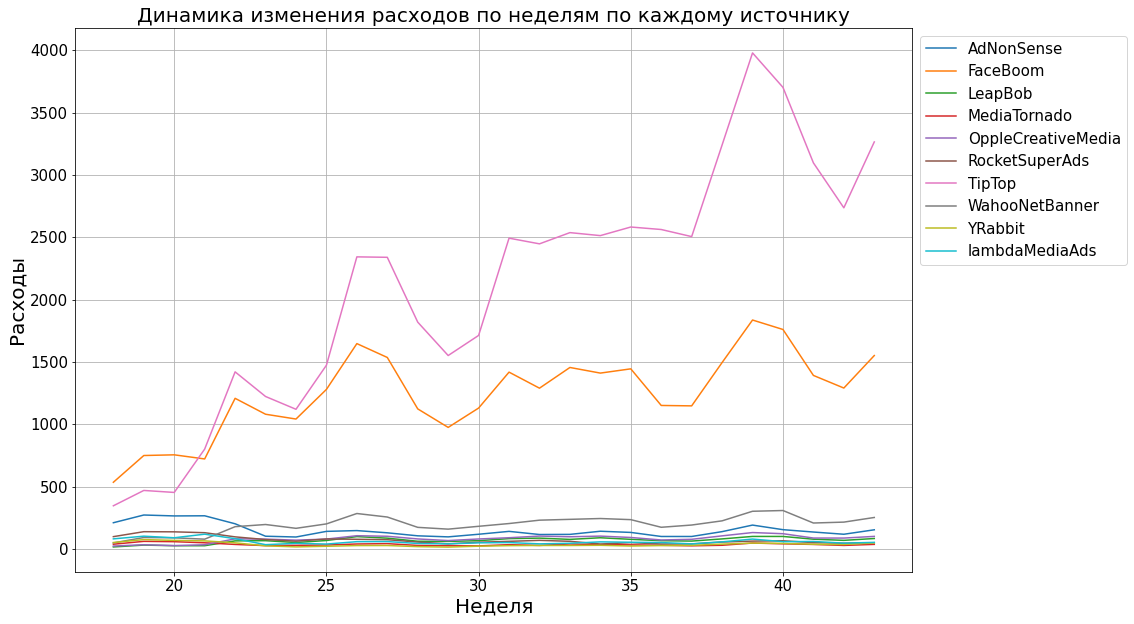

In [43]:
%matplotlib inline
costs_visualisation('week')

Строим график с визуализацией динамики изменения расходов во времени по месяцам:

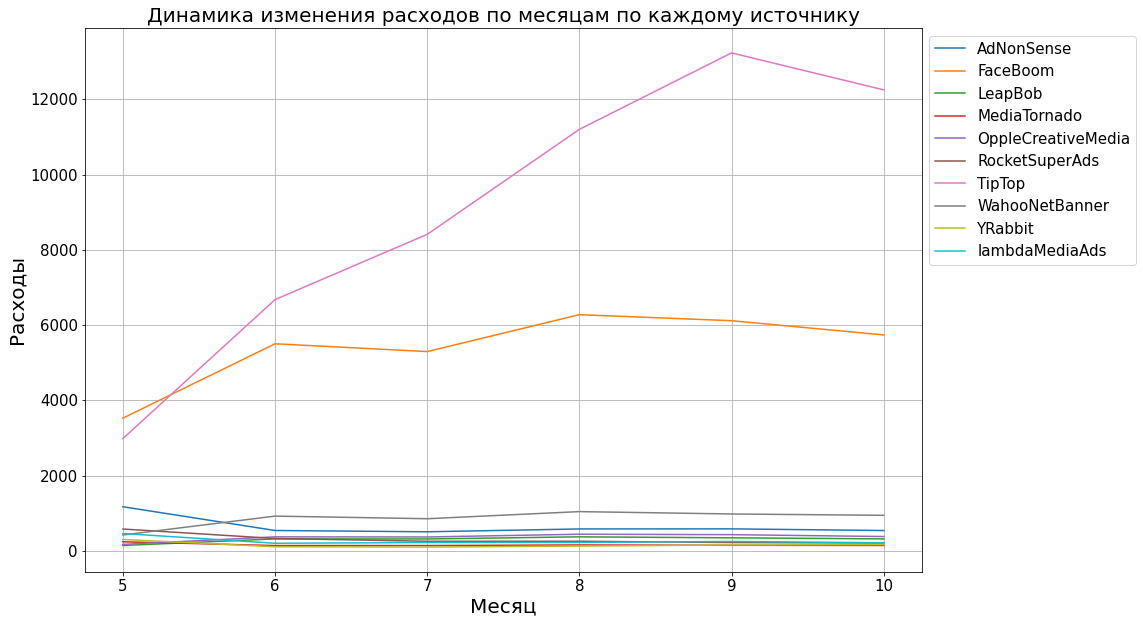

In [44]:
costs_visualisation('month')

**Вывод:** по графикам также видим, что лидерами по расходам на рекламу являются такие источники, как FaceBoom и TipTop. Расходы на рекламу в этих источниках только растут с каждым месяцем, для TipTop наблюдаем более резкий рост расходов, а для FaceBoom рост более плавный и последние 2 месяца расходы несного сократились. При этом из недельного графика видим, что в начале июня, июля и конце августа расходы на рекламу сокращали для обоих источников одновременно.Для остальных источников расходы более скромные и равномерные, без скачков.

**4.4.** Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [45]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .sort_values(by='acquisition_cost', 
                    ascending=False)
      )
cac['acquisition_cost'] = round(cac['acquisition_cost'], 2)
cac

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


In [63]:
# считаем средний САС без учета органического источника
round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2)

1.13

Посмотрим, как виузально меняется средняя стоимость привлечения в течение рассматриваемого периода:

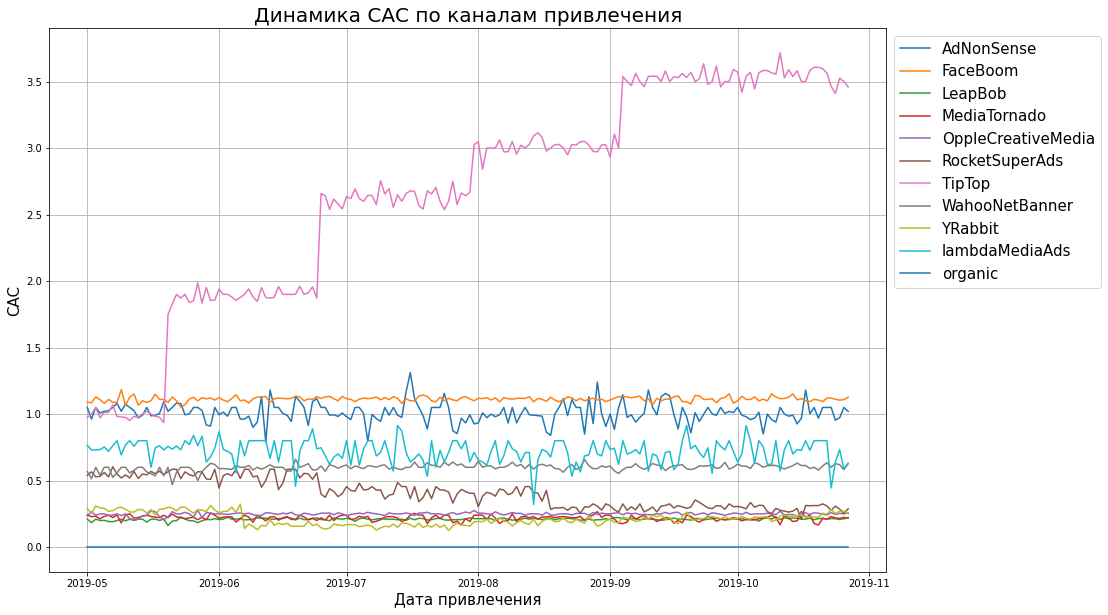

In [47]:
(profiles.pivot_table(index='dt', 
                     columns='channel', 
                     values='acquisition_cost', 
                     aggfunc='mean')
 .plot(grid=True, figsize=(15, 10))
)
plt.title('Динамика САС по каналам привлечения', fontsize=20)
plt.ylabel('CAC', fontsize=15)
plt.xlabel('Дата привлечения', fontsize=15)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', fontsize=15)
plt.show()

**Вывод:** дороже всего привлекать клиентов на TipTop, средняя стоимость привлечения для этого источника - 2,8. Из графика видим, что в начале мая стоимость привлечения для TipTop, FaceBoom и AdNonSense была на одном уровне - 1 единица. В середина мая стоимость привлечения на TipTop резко выросла и далее только росла, тогда как для остальных источников стоимость колеблется на одном уровне.

**Общий вывод:** 
- сумма расходов на маркетинг составила 105497.3; 
- больше всего вложено денег в рекламу на таких источниках, как TipTop (54751,3) и FaceBoom (32445,6). Расходы на рекламу в них растут с каждым месяцем. Эти же источники принесли больше всего пользователей;
- средний САС по всему проекту составил 1.08. На его фоне выделяется TipTop, средняя стоимость привлечения пользователей составила 2,8. При этом за полгода САС для TipTop выросла почти в три раза, тогда как САС для остальных источников осталась на своем начальном уровне;
- расходы на "органический" источник равны нулю, так как "органические" пользователи пришли в приложение самостоятельно, не через рекламу.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Зададим момент и горизонт анализа. Минимальную и максимальную даты привлечения пользователей мы определяли выше. Так как мы располагаем данными только по 27 октября 2019 года, то будем использовать эту дату в качестве момента анализа.

In [48]:
# момент анализа
observation_date = max_date

# горизонт анализа
horizon_days = 14

# опция «игнорировать горизонт»
ignore_horizon = False

In [49]:
# максимально возможная дата привлечения
last_suitable_acquisition_date = observation_date
if not ignore_horizon:
    last_suitable_acquisition_date = observation_date - timedelta(
        days=horizon_days - 1
    )

In [50]:
# исключаем пользователей, пришедших после максимальной даты привлечения,
# а также исключим из данных "органических" пользователей
profiles = profiles.query('channel != "organic"')
result_raw =  (
    profiles.query('dt <= @last_suitable_acquisition_date')
    .sort_values(by='first_ts')
)
# проверка данных
result_raw.tail()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
112492,749435514245,2019-10-14 23:38:07,FaceBoom,Mac,United States,2019-10-14,2019-10-01,False,1.151333
101441,676165471639,2019-10-14 23:46:52,TipTop,iPhone,United States,2019-10-14,2019-10-01,False,3.538043
143533,957668393147,2019-10-14 23:49:32,OppleCreativeMedia,PC,UK,2019-10-14,2019-10-01,False,0.243902
80570,535062591756,2019-10-14 23:53:10,YRabbit,iPhone,United States,2019-10-14,2019-10-01,False,0.233182
143567,957901295887,2019-10-14 23:59:58,RocketSuperAds,iPhone,United States,2019-10-14,2019-10-01,False,0.270833


Видим, что максимально возможная дата привлечения - 14 октября 2019. Пользователи из более поздних дат еще не успели "прожить" необходимые нам 14 дней. 

**5.1.** Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

**LTV** — общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок.

**CAC** — стоимость привлечения одного клиента. Сумма денег, в которую компании обходится каждый новый клиент. В сущности, CAC — это инвестиции в маркетинг.

**ROI** — окупаемость инвестиций. В экономике одного покупателя эта метрика показывает, на сколько процентов LTV превысил CAC, то есть на сколько процентов «окупились» клиенты.


Для построения графиков рассчитаем LTV и ROI, а потом на основе полученных данных посторим графики. Для этого используем заданные раннее фуннкции `get_ltv` и `plot_ltv_roi`:

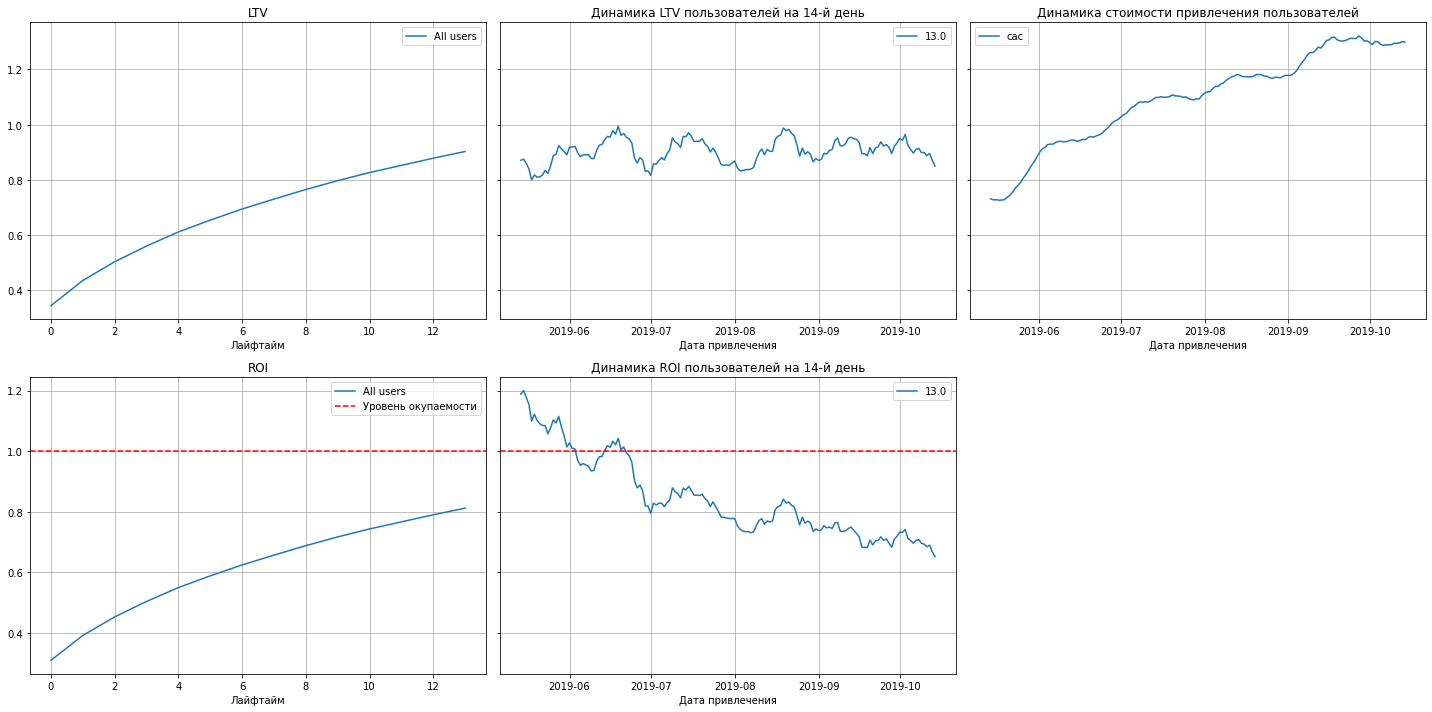

In [51]:
# рассчитываем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Из графиков видим следующее:
- на 14 день ROI чуть выше 80 % и находится ниже уровня окупаемости, реклама не окупается. На графике динамики видим, что в начале - до середины июня - инвестиции окупались, но потом ROI начал падать
- в динамике LTV сильно не изменяется и достаточно стабилен
- САС все время растет, значит, бюджет на рекламу увеличивается.

Пока все выглядит так, как будто реклама слишком дорого обходится компании. Но выводы делать рано.

**5.2.** Рассмотрим теперь окупаемость рекламы с разбивкой по следующим характеристикам:
- устройство, с которого пользователь зашел в приложение
- страна пользователя
- источник, с которого пользователь пришел в приложение

**5.2.1.** Устройство входа:

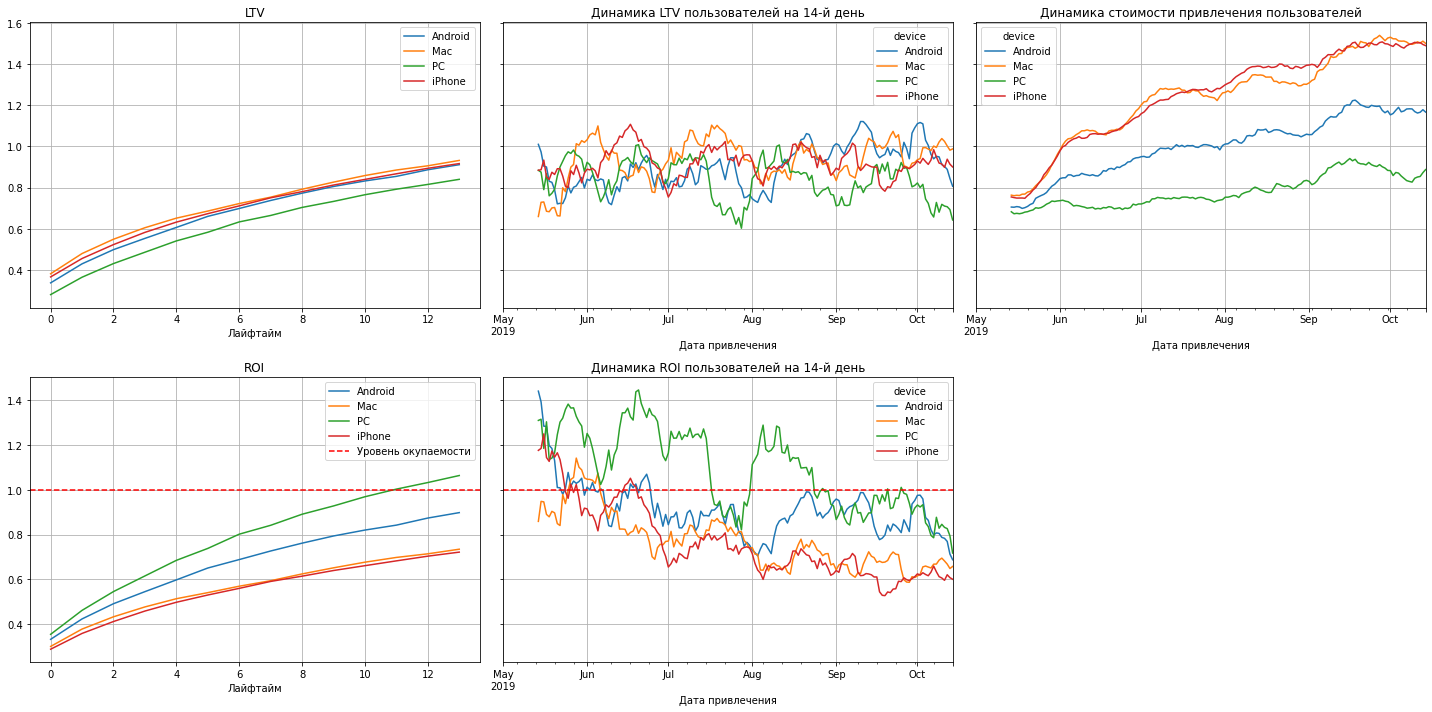

In [52]:
dimensions = ['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv, ltv_history, roi, roi_history, horizon_days, window=14
) 

- клиенты c PC приносят меньше денег компании, чем клиенты на других устройствах. Для Android, Mac и iPhone LTV находятся на одном уровне
- несмотря на то, что LTV для PC самое низкое, только клиенты с этих устройств окупились. По динамике видим, что с мая по август ROI почти всегда держалось выше уровня окупаемости, тогда как для остальных устройств ROI опустилось ниже уровня окупаемости уже в мае.
- самое стабильная стоимость привлечения покупателя для PC, для остальных устройств САС растет, особенно заметен рост для Mac и iPhone 

Нужно обратить внимание на пользователей с такими устройствами, как iPhone и Mac. Их САС растет, а ROI сильно ниже уровня окупаемости.

**5.2.2.** Страна:

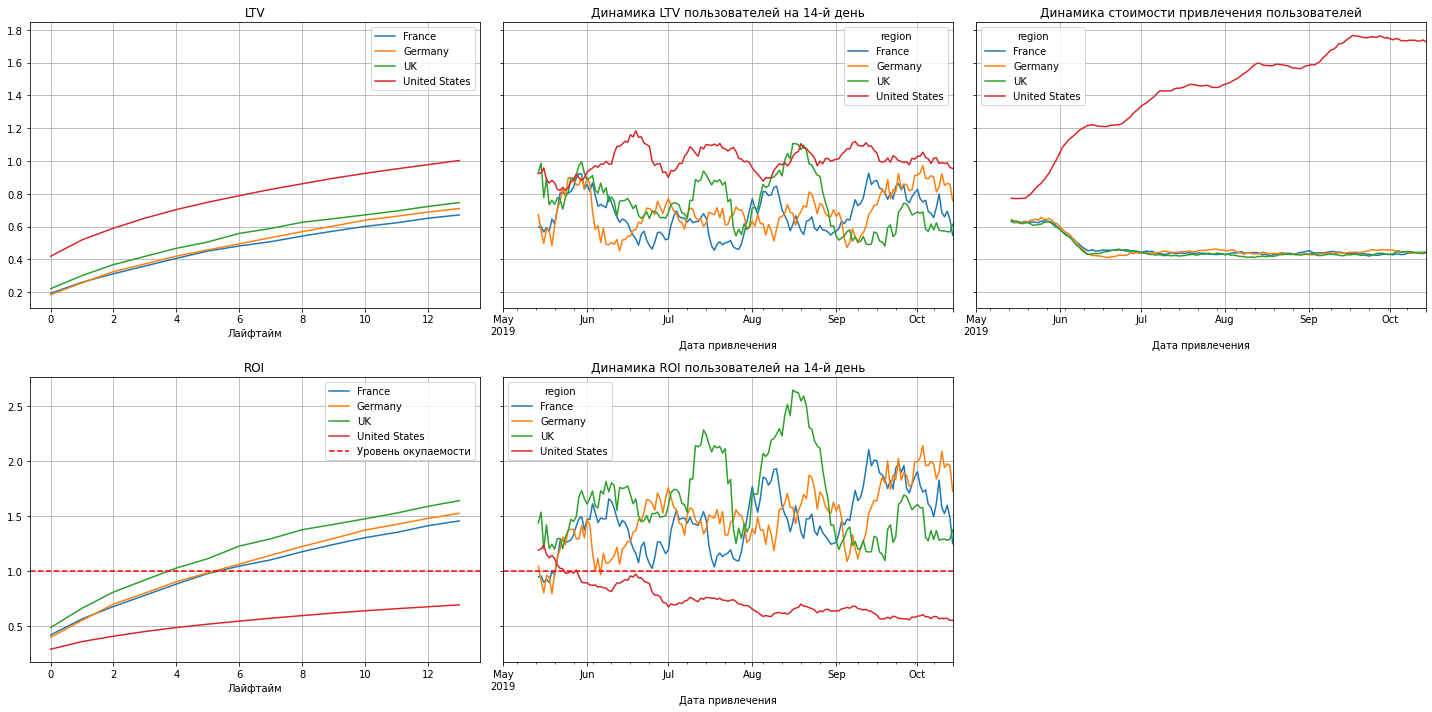

In [53]:
dimensions = ['region']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv, ltv_history, roi, roi_history, horizon_days, window=14
) 

- клиенты из США приносят больше всего денег
- самая высокая стоимость привлечения для клиентов из США, с каждым месяцем она только растет. Для остальных стран САС в июне понизилась и с тех пор держится на одном уровне
- несмотря на самый высокий и стабильный LTV, инвестиции в пользователей США не окупаются и выходят на стадию плато

Здесь нужно обратить внимание на американских пользователей. Рассмотрим их отдельно позже.

**5.2.3.** Источник рекламы:

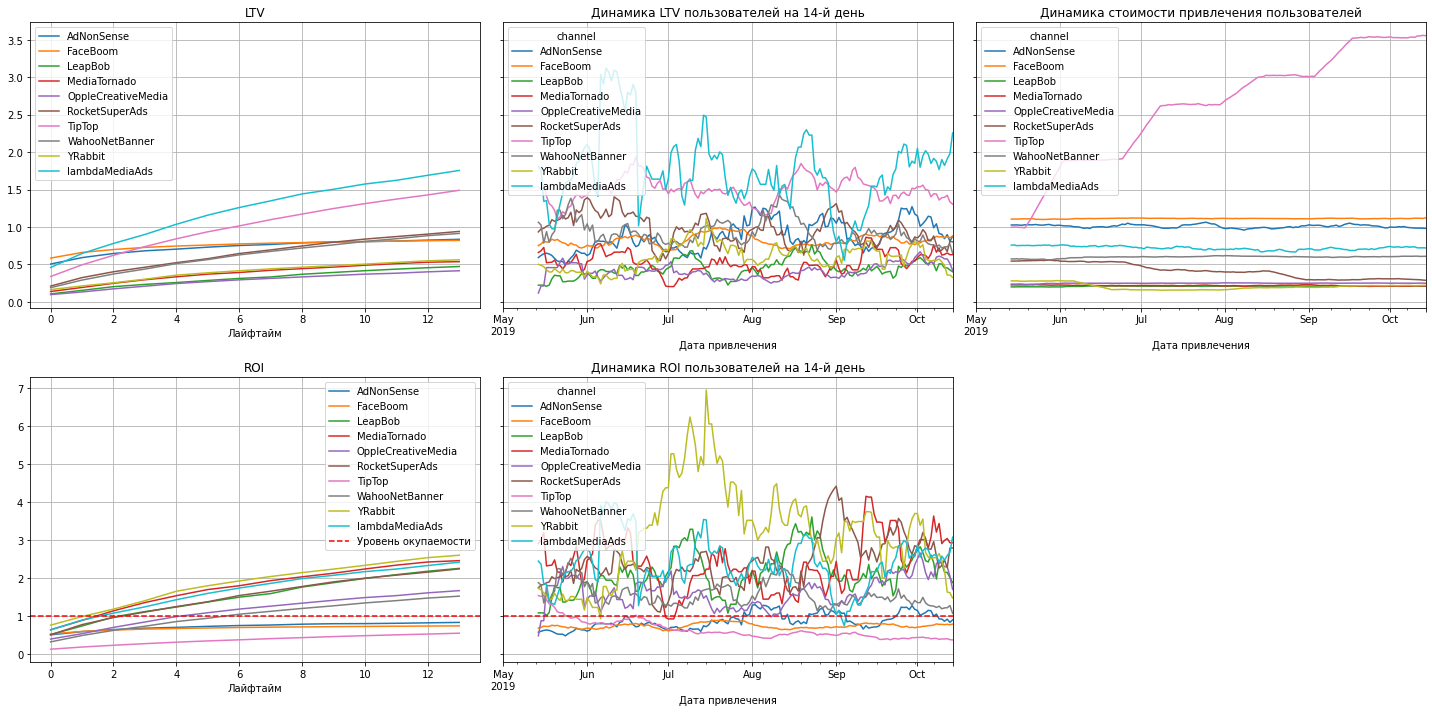

In [54]:
dimensions = ['channel']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv, ltv_history, roi, roi_history, horizon_days, window=14
) 

- рекламные источники (FaceBoom, TipTop, AdNonSense), с которых пришло больше всего пользователей, среди которых и одни из самых высоких процентов плательщиков, не окупились. Из динамики видим, что FaceBoom и AdNonSense ни разу не поднимались выше уровня окупаемости. Источник YRabbit в летний период показал хорошую окупаемость.
- САС для TipTop резко выделяется на графике и растет с каждым месяцем. Для остальных источников САС стабилен

Теперь рассмотрим отдельно американских пользователей 

- разбивка пользователей США по устройствам: 

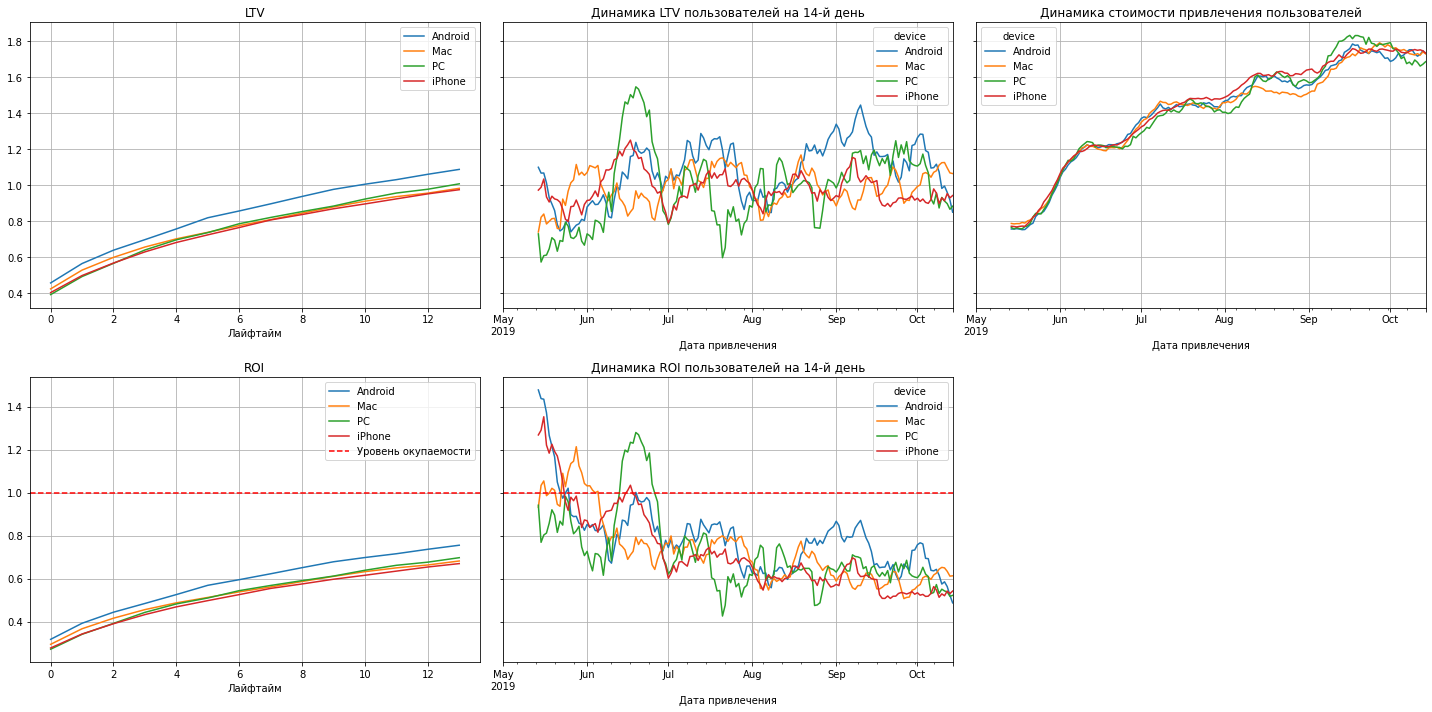

In [55]:
dimensions = ['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv, ltv_history, roi, roi_history, horizon_days, window=14
) 

В США окупаемость для всех устройств низкая и не превышает уровня окупаемости, стоимость привлечения растет одинаково. 

- разбивка пользователей США по источникам рекламы: 

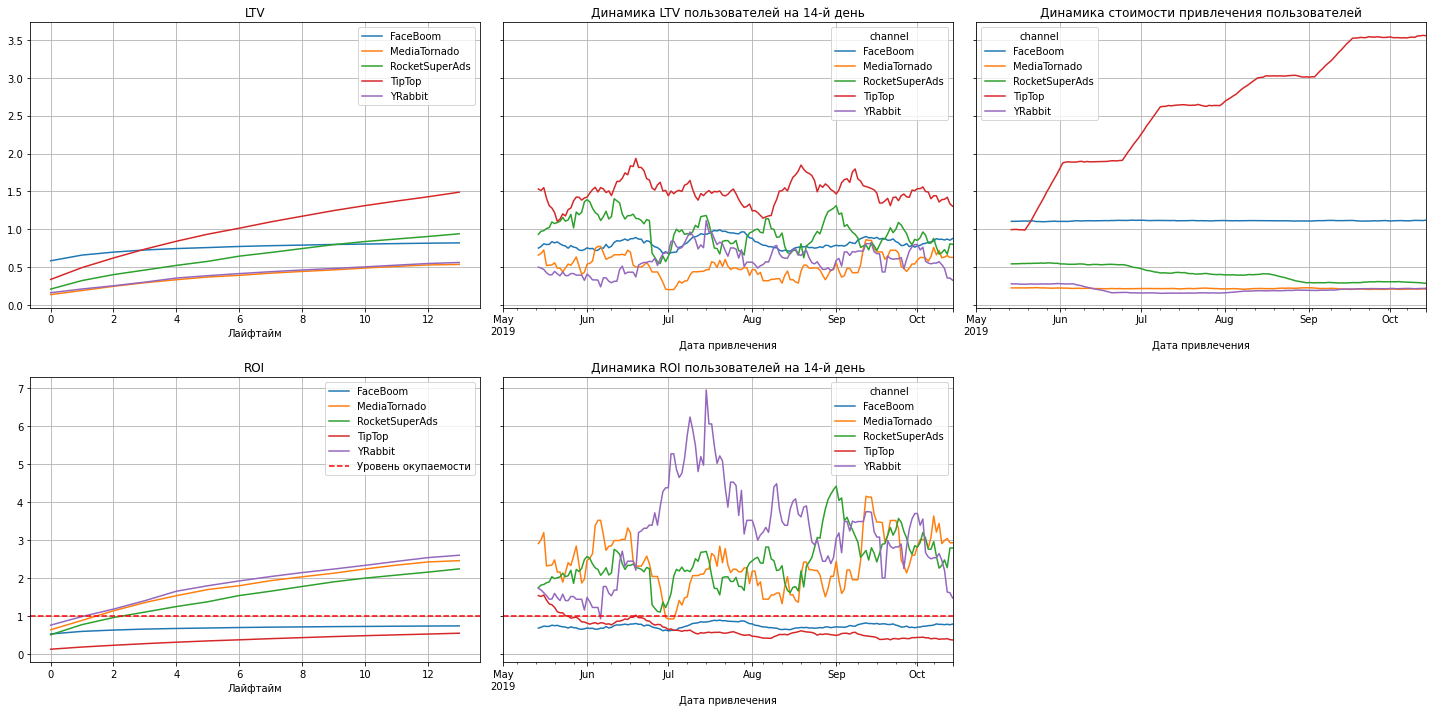

In [56]:
dimensions = ['channel']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv, ltv_history, roi, roi_history, horizon_days, window=14
) 

В США самыми высокими расходами были расходы на рекламу в TipTop, но расходы не окупились. Также не окупились расходы на FaceBoom.

**Вывод:** плохие результаты показывают такие устройства, как iPhone и Mac. По странам самые плохие показатели в США, а самый выделяющийся рекламный источник - TipTop, который находится в США. Компании нужно обратить особое внимание на расходы на рекламу в TipTop, так как они очень высокие и не окупаемые.

**5.3.** Проверим конверсию пользователей, удержание пользователей и динамику их изменения.

**Конверсия (CR, или Conversion Rate)** — это доля пользователей, перешедших из одного состояния в другое.

**Удержание (RR, или Retention Rate)** показывает, сколько пользователей из когорты относительно их изначального числа вернулись в последующие периоды, то есть вновь воспользовались продуктом или услугой.

Для построения графиков рассчитаем конверсию и удержание, а потом на основе полученных данных посторим графики. Для этого используем заданные раннее фуннкции `get_conversion` и `plot_conversion`.

**5.3.1** Используем разбивку по устройствам:

- конверсия:

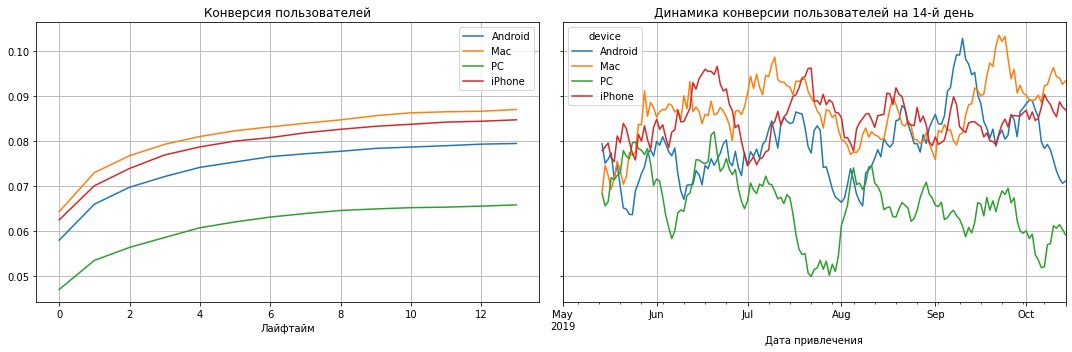

In [57]:
# задаем разбивку по устройствам
dimensions=['device']
# рассчитываем конверсию 
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
# строим графики
plot_conversion(conversion, conversion_history, horizon_days, window=14)

- удержание пользователей:

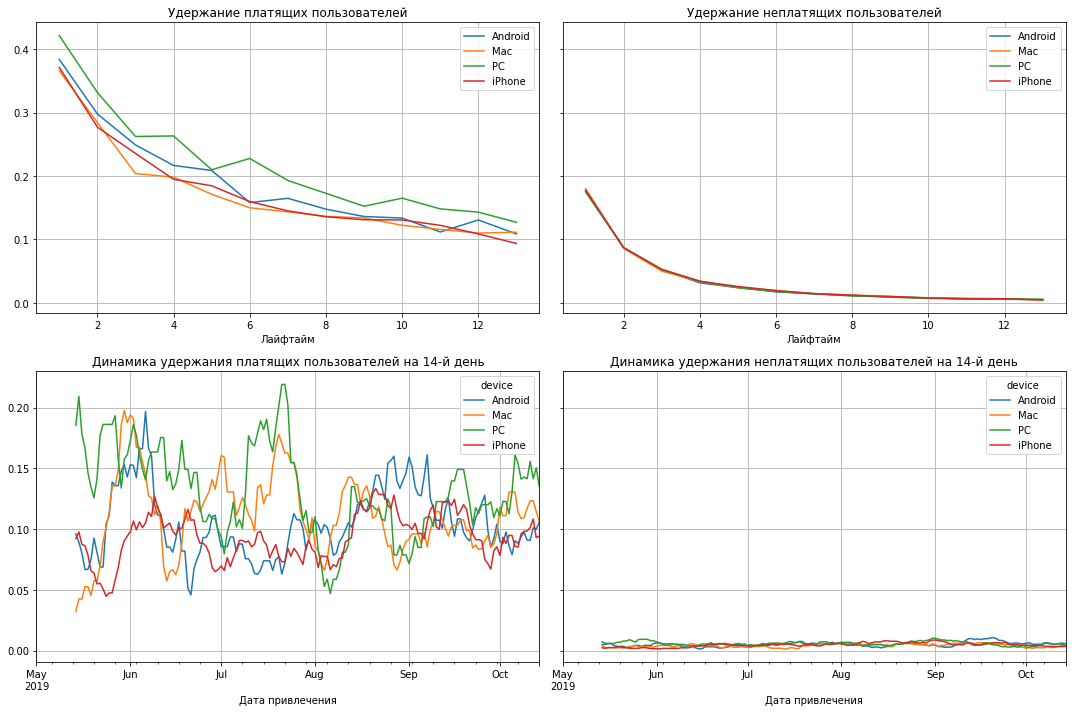

In [58]:
dimensions=['device']
# рассчитываем удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
# строим графики
plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

Платящие пользователи PC конвертируются хуже всего, а устройства Apple показывают лучшие результаты. При этом платящие пользователи лучше удерживаются на PC.

**5.3.2** Используем разбивку по странам:

- конверсия:

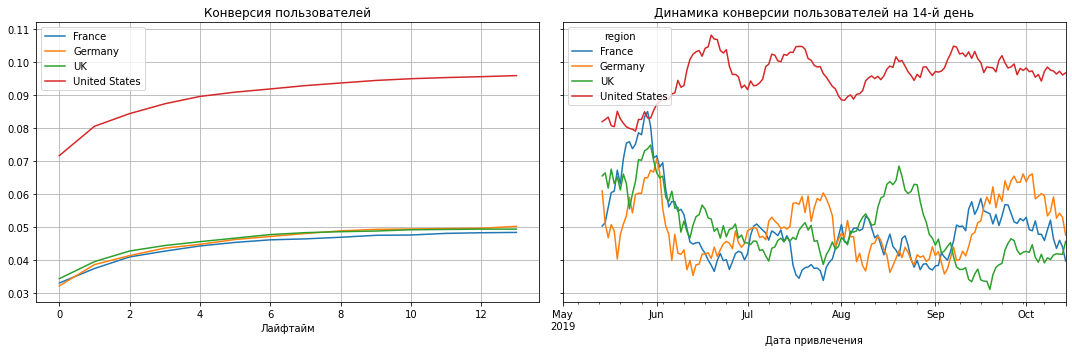

In [59]:
# задаем разбивку по странам
dimensions=['region']

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

- удержание пользователя:

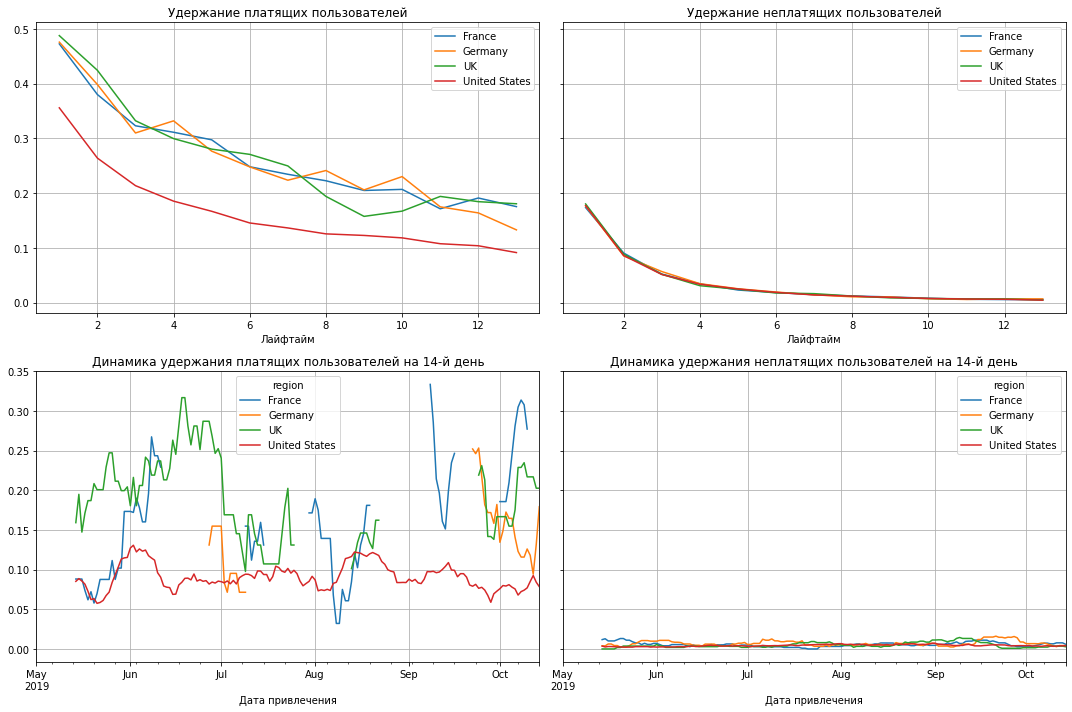

In [60]:
dimensions=['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

Американцы конвертируются почти в 2 раза больше, чем пользователи остальных стран, но они показывают худшее удержание.

**5.3.3** Используем разбивку по источникам рекламы:

- конверсия:

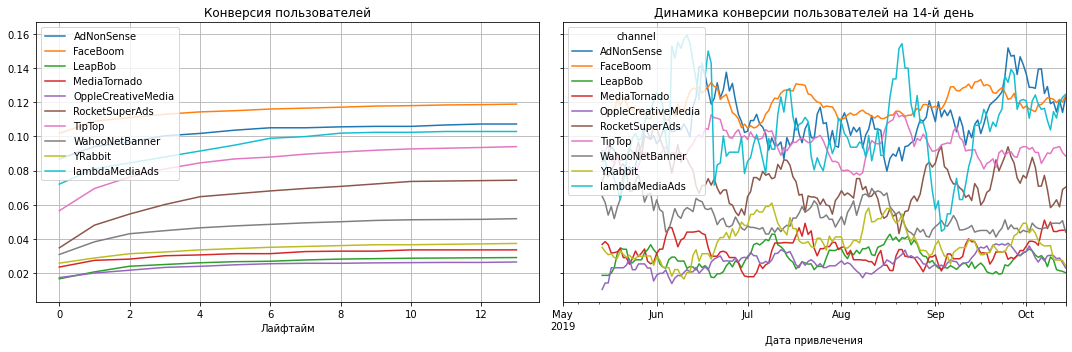

In [61]:
# задаем разбивку по источникам
dimensions=['channel']

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

- удержание пользователя:

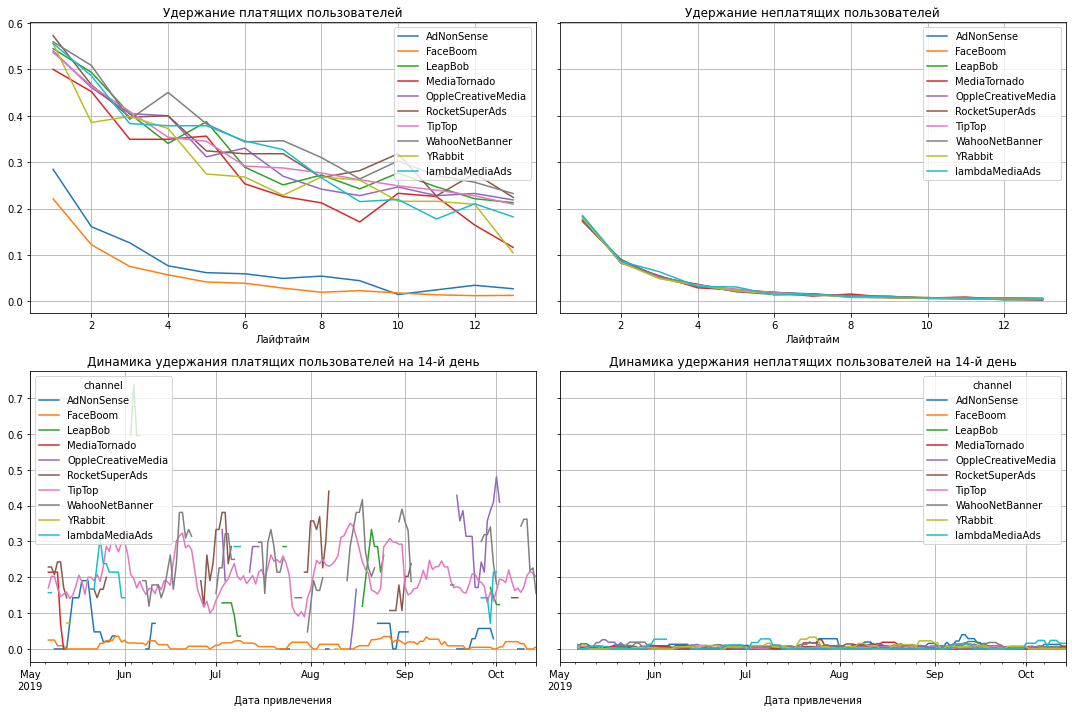

In [62]:
dimensions=['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=7) 

Самая высокая конверсия пользователей, пришедших с таким источников, как FaceBoom и AdNonSense, но удержания этих пользователей сильно ниже удержания пользователей из остальных источников.

**Общий вывод:** 

- в целом реклама не окупается. Основной вклад вносит низкая окупаемость в США. При этом стоимость привлечения пользователей растет, несмотря на низкие показатели ROI;
- самые низкие показатели у такого рекламного источника, как TipTop. Его САС растет с каждым месяцем, но уровень окупаемости стабильно меньше 100 %;
- из 4 устройств окупились только пользователи на PC. Устройства Apple показали худший результат: их САС растет, а ROI не превышает уровня окупаемости и продалжает падать
- хорошую конверсию показывают пользователи из Америки, но при этом у них самая низкое удержание. Также при самой высокой конверсии, пользователи, пришедшие с FaceBoom и AdNonSense, удеживаются хуже всего.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Итоговый вывод:**

В ходе анализа были изучены данные пользователей приложения ProcrastinatePro+. Данное приложение представлено в таких странах, как США, Великобритания, Франция и Германия. Основным рынком является США с пользовательской базой в 100 тысяч пользователей. На остальные страны приходится 50 тысяч пользователей суммарно. Среди устройств лидером по скачиванию является iPhone. Больше всего пользователей привлекли такие источники рекламы, как FaceBoom и TipTop: 29144 и 19561 соответственно. FaceBoom также принес больше всего платящих пользователей. Следующим по проценту платящих пользователей идет такой источник, как AdNonSense, с которого пришло почти меньше всего пользователей: на 3880 пользователей приходится 11,3 % платящих пользователей.

При изучении маркетинговых раходов было выяснено, что больше всего вложено денег в рекламу на таких источниках, как TipTop (54751,3) и FaceBoom (32445,6). Самые дорогие пользователи пришли из TipTop, средняя стоимость их привлечения составила 2,8. При этом за полгода САС для TipTop выросла почти в три раза. 

При оценке окупаемости рекламы выяснили, что в целом реклама не окупается. Основной проблемой являются чрезмерные расходы на привлечение пользователей. Самая высокая стоимость привлечения покупателя наблюдается в США для источника рекламы TipTop, при этом по этим двум характеристикам наблюдается стабильное понижение окупаемости. Также видна закономерность: с увеличением САС падает ROI. TipTop и FaceBoom показывают самое низкое удержание пользователей при самой высокой конверсии.
По устройствам только PC окупается к концу второй недели и имеет самый низкий САС, а также показывает хорошее удержание с самой низкой конверсией.

**Рекомендации:**

Как было сказано выше, в Америке больше всего пользователей, они показывают лучшую конверсию и LTV среди всех пользователей, но при этом у них худшая окупаемость (в мае она упала ниже уровня окупаемости) и удержание. ROI можно поднять сокращением трат на рекламу в TipTop, так как видна закономерность: поднятие стоимости привлечения в мае и одновременное падение окупаемости. Можно ввести акции и бонусы, которые бы форсировали пользователей платить чаще и больше. Также стоит обратить внимание на FaceBoom, реклама там не окупается вообще. Стоит изучить аудиторию на FaceBoom, их интересы и опять же добавить какие-то акции, чтобы новые пользователи не только устанавливали приложение, но и делали внутренние покупки. Стоит обратить внимание и на другие каналы привлечения пользователей - RocketSuperAds, YRabbit, MediaTornado. Суммарно они принесли меньше пользователей, чем TipTop или FaceBoom, но при этом у них выше показатели LTV, ROI и удержание. Отстает только конверсия. Здесь можно изучить саму рекламу и, возможно, переделать ее, то, как платформы ее продвигают, видит ли ее наша целевая аудитория.

Перед выполнением этих рекомендаций стоит обратить внимание на европейский источник рекламы - lambdaMediaAds. Этот источник отлично себя показывает по всем показателям. 

Не стоит забывать и уже про имеющихся пользователей, ведь такие пользователи выгоднее для компании. Для поднятия их LTV и удержания можно внедрить какие-то новые функции в приложении, чтобы они вновь вернулись к нам. Не забываем про бонусы и акции. 

Стоит подумать над увеличением пользовательской базы в Европе. Там хорошее удержание, реклама окупается, стабильный LTV, но низкая конверсия. Конверсию можно увеличить за счет специальных предложений или продумать более удобную оплату для пользователей, так как большая часть европейцев используют андроид и ПК, на которых нет такого удобного способа оплаты, как ApplePay. Пользователи просто могут лениться вводить данные карточки. Для увеличения пользовательской базы стоит изучить аудиторию, рекламу, способы ее показа. Если в приложении присутствует только английский язык, то нужно добавить поддержку французского и немецкого языка.

Треть наших пользователей пришли к нам не из рекламы. Но из 56 тысяч пользователей только 2 процента (1159 пользователей) совершили покупку. Возможно, в самом приложении нет специальных предложений, промокодов и привлекающих заголовков, стимулирующих пользователя платить.